In [29]:
# Check the version of python
!python -V

Python 3.11.5


In [80]:
# Import neccessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import StandardScaler, PolynomialFeatures


from sklearn.metrics import r2_score, mean_squared_error
from functools import partial
rmse = partial(mean_squared_error, squared=False)

import warnings 
warnings.filterwarnings("ignore")

%config InlineBackend.figure_formats = set(('retina', 'svg'))
plt.figure(figsize=(9,6))
%matplotlib inline

<Figure size 900x600 with 0 Axes>

In [31]:
# load in the parquet file
train = pd.read_parquet('../data/green_tripdata_2023-01.parquet')

In [32]:
train.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2023-01-01 00:26:10,2023-01-01 00:37:11,N,1.0,166,143,1.0,2.58,14.9,1.0,0.5,4.03,0.0,None,1.0,24.18,1.0,1.0,2.75
1,2,2023-01-01 00:51:03,2023-01-01 00:57:49,N,1.0,24,43,1.0,1.81,10.7,1.0,0.5,2.64,0.0,None,1.0,15.84,1.0,1.0,0.00
2,2,2023-01-01 00:35:12,2023-01-01 00:41:32,N,1.0,223,179,1.0,0.00,7.2,1.0,0.5,1.94,0.0,None,1.0,11.64,1.0,1.0,0.00
3,1,2023-01-01 00:13:14,2023-01-01 00:19:03,N,1.0,41,238,1.0,1.30,6.5,0.5,1.5,1.70,0.0,None,1.0,10.20,1.0,1.0,0.00
4,1,2023-01-01 00:33:04,2023-01-01 00:39:02,N,1.0,41,74,1.0,1.10,6.0,0.5,1.5,0.00,0.0,None,1.0,8.00,1.0,1.0,0.00


In [33]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68211 entries, 0 to 68210
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               68211 non-null  int64         
 1   lpep_pickup_datetime   68211 non-null  datetime64[us]
 2   lpep_dropoff_datetime  68211 non-null  datetime64[us]
 3   store_and_fwd_flag     63887 non-null  object        
 4   RatecodeID             63887 non-null  float64       
 5   PULocationID           68211 non-null  int64         
 6   DOLocationID           68211 non-null  int64         
 7   passenger_count        63887 non-null  float64       
 8   trip_distance          68211 non-null  float64       
 9   fare_amount            68211 non-null  float64       
 10  extra                  68211 non-null  float64       
 11  mta_tax                68211 non-null  float64       
 12  tip_amount             68211 non-null  float64       
 13  t

In [34]:
train.drop(columns='ehail_fee', inplace=True)

In [35]:
# Check for missing values
train.isna().sum()

VendorID                    0
lpep_pickup_datetime        0
lpep_dropoff_datetime       0
store_and_fwd_flag       4324
RatecodeID               4324
PULocationID                0
DOLocationID                0
passenger_count          4324
trip_distance               0
fare_amount                 0
extra                       0
mta_tax                     0
tip_amount                  0
tolls_amount                0
improvement_surcharge       0
total_amount                0
payment_type             4324
trip_type                4334
congestion_surcharge     4324
dtype: int64

In [36]:
# Drop all features containing missing values
train.dropna(inplace=True)

In [37]:
train.isna().sum().any()

False

In [38]:
# To get the duration for each trip
train['duration'] = train['lpep_dropoff_datetime'] - train['lpep_pickup_datetime']

In [39]:
train['duration']

0       0 days 00:11:01
1       0 days 00:06:46
2       0 days 00:06:20
3       0 days 00:05:49
4       0 days 00:05:58
              ...      
63882   0 days 00:07:59
63883   0 days 00:10:45
63884   0 days 00:06:01
63885   0 days 00:09:32
63886   0 days 00:09:56
Name: duration, Length: 63877, dtype: timedelta64[us]

In [40]:
# convert the duration columns to minutes usinng inbuilt function [total_seconds()]
train['duration'] = train['duration'].apply(lambda x :x.total_seconds() / 60)

In [41]:
# Check the descriptive statistic of the duration column
train['duration'].describe()

count    63877.000000
mean        17.973569
std         77.301793
min          0.000000
25%          7.083333
50%         11.100000
75%         16.883333
max       1439.883333
Name: duration, dtype: float64

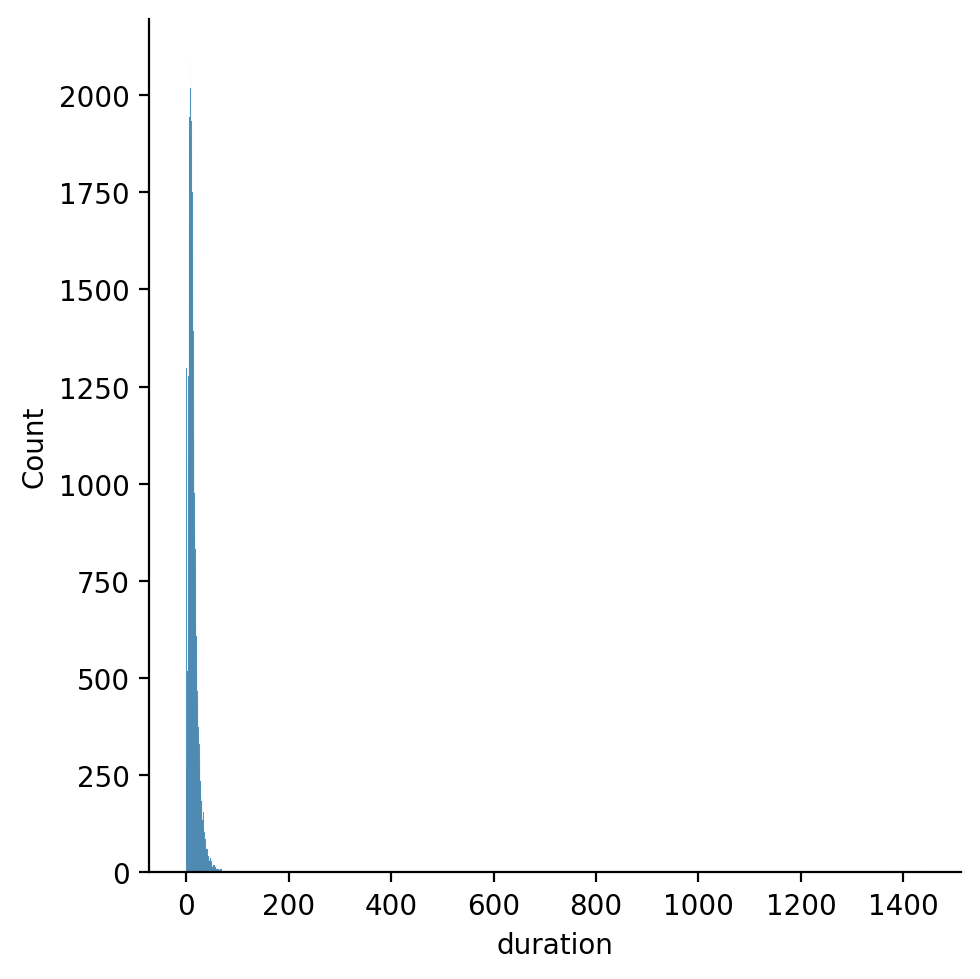

In [42]:
sns.displot(train['duration']);

In [43]:
train['duration'].value_counts()

duration
0.050000       163
0.083333       148
0.066667       145
0.033333       140
7.350000        98
              ... 
51.533333        1
62.400000        1
48.383333        1
1391.750000      1
259.633333       1
Name: count, Length: 3628, dtype: int64

In [44]:
train.shape

(63877, 20)

In [45]:
# check number of trip's duration less than 1 minute
len(train.query('duration<1'))

1641

In [46]:
# check number of trip's duration greater than 60 minutes i.e 1 hour
len(train.query('duration>60'))

585

Let's check correlation between duration and `trip_distance`

In [47]:
lessthan1 = train.query('duration<1')

<Axes: xlabel='duration', ylabel='trip_distance'>

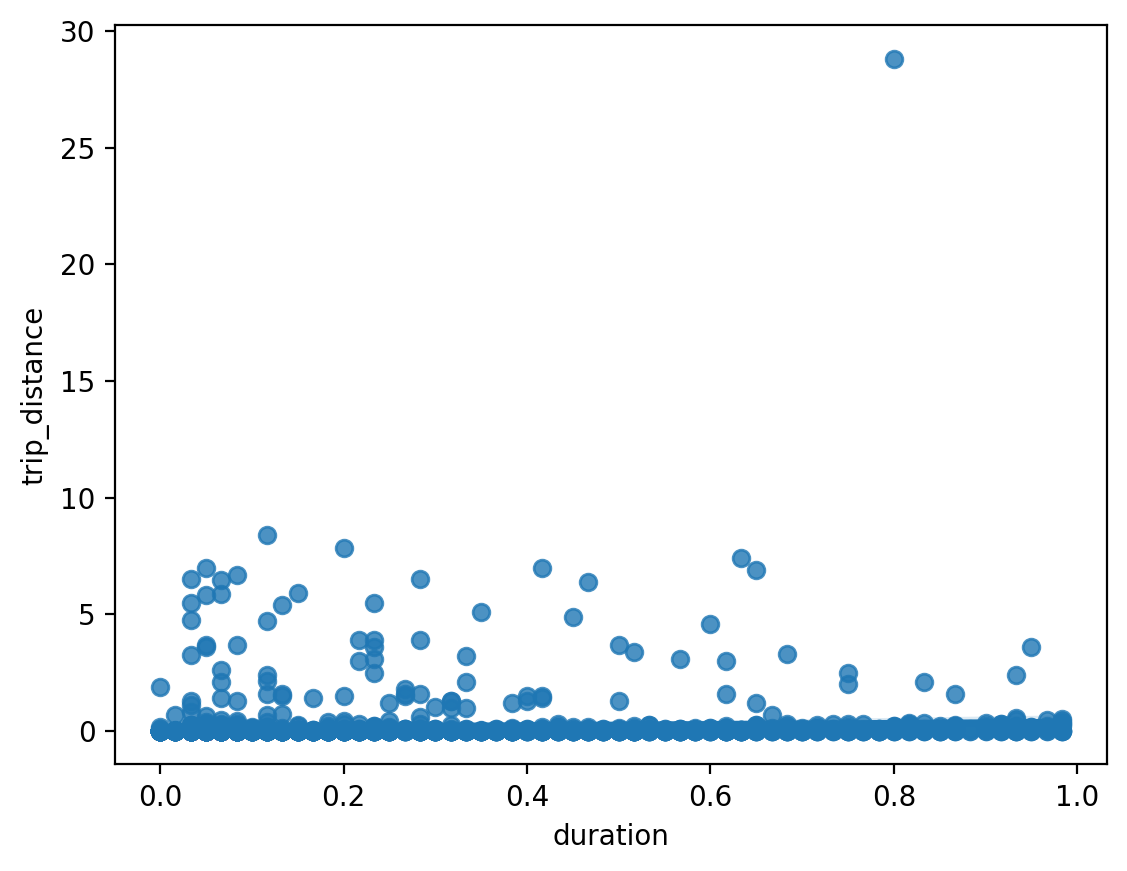

In [48]:
sns.regplot(x='duration', y='trip_distance', data=lessthan1)

In [49]:
lessthan1[['duration','trip_distance']].sort_values(by='trip_distance', ascending=False)

,duration,trip_distance
40820,0.800000,28.80
40754,0.116667,8.41
63810,0.200000,7.84
22873,0.633333,7.40
48608,0.416667,6.99
...,...,...
22858,0.050000,0.00
22785,0.116667,0.00
22783,0.933333,0.00
22724,0.016667,0.00


In [50]:
greaterthan60 = train.query('duration>60')

<Axes: xlabel='duration', ylabel='trip_distance'>

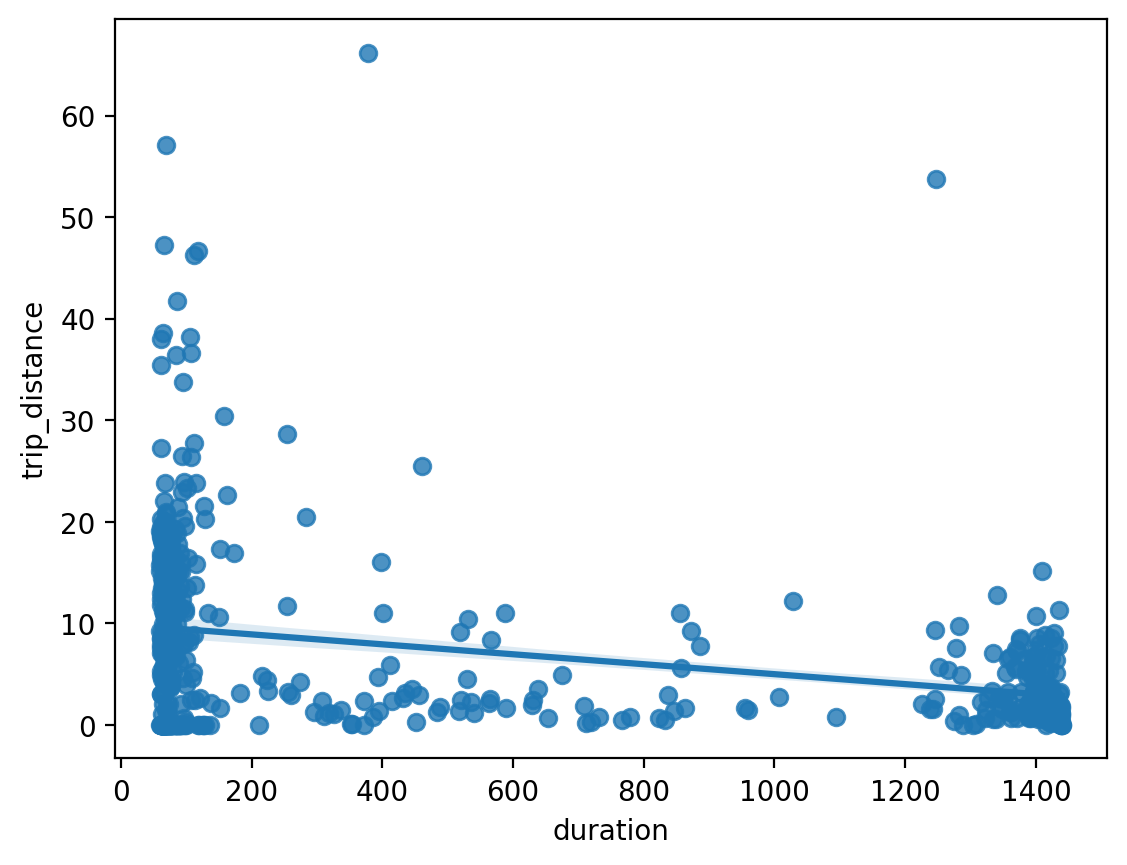

In [51]:
sns.regplot(x='duration', y='trip_distance', data=greaterthan60)

This is not a detailed project focused on getting deep insights and perfect model score. We will continue by subsetting the data i.e keep all observations between 1 minute and 60 minutes

In [52]:
train = train[train['duration'].between(1, 60)]

Selecting features we think my affect or determine duration of a trip

In [53]:
train.columns

Index(['VendorID', 'lpep_pickup_datetime', 'lpep_dropoff_datetime',
       'store_and_fwd_flag', 'RatecodeID', 'PULocationID', 'DOLocationID',
       'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount',
       'payment_type', 'trip_type', 'congestion_surcharge', 'duration'],
      dtype='object')

In [56]:
features = ['PULocationID', 'DOLocationID', 'trip_distance', 'tolls_amount', 'trip_type']
features_df = train[features]

We have encoded the categorical variables which are `['PULocationID', 'DOLocationID', 'trip_type']`

### Build a preprocessing pipeline

In [60]:
features_df['trip_type'] = features_df['trip_type'].astype(int)

In [63]:
seed=1234
X_train, X_test, y_train, y_test = train_test_split(features_df, train['duration'], test_size=0.25, random_state=seed)

In [64]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((46238, 5), (15413, 5), (46238,), (15413,))

In [61]:
def preprocessor_pipe():
    numeric_features = features
    numeric_transformer = Pipeline(
        steps=[
            # its a good practice to do the polynomial/interaction feature generation before scaling.
            ("poly_int", PolynomialFeatures(interaction_only=True, include_bias=False)),
            ("scaler", StandardScaler())
        ]
    ).set_output(transform='pandas')


    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features)
        ],
        remainder='passthrough',
        verbose_feature_names_out=False
    ).set_output(transform="pandas")

    return preprocessor

In [68]:
def model_selection(xtrain,xtest,ytrain,ytest):
    models = {
        'linear_regression':{
            'model':LinearRegression()
        },
        'random_forest':{
            'model':RandomForestRegressor(random_state=seed)
        },
        'lasso':{
            'model':Lasso(random_state=seed)
        },
        'ridge':{
            'model': Ridge()
        }
    }

    scores = []
    for model_name, config in models.items():
        config['model'].fit(xtrain, ytrain)
        y_pred = config['model'].predict(xtest) 
        train_score = config['model'].score(xtrain, ytrain)
        rmse_ = rmse(ytest, y_pred)
        r2score = r2_score(ytest, y_pred)
        scores.append({
            'model': model_name,
            'train_score':train_score,
            'RMSE':rmse_,
            'r2_score':r2score})

    return pd.DataFrame(scores,columns=['model','train_score','RMSE','r2_score'])

In [69]:
results = model_selection(X_train, X_test, y_train, y_test)

In [70]:
results

,model,train_score,RMSE,r2_score
0,linear_regression,0.111207,8.172113,0.127517
1,random_forest,0.923159,5.037758,0.668439
2,lasso,0.097888,8.201878,0.121150
3,ridge,0.111207,8.172111,0.127517


In [71]:
def model_pipe(est):
    """ """
    pipe = Pipeline(
        steps=[
            ("pp", preprocessor_pipe()),
            ("regr", est)
        ]
    ).set_output(transform="pandas")

    return pipe

In [81]:
def evaluate(model):
    scores = []
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test) 
    train_score = round(model.score(X_train,y_train),3)
    rmse_ = round(rmse(y_test, y_pred),3)
    r2score = round(r2_score(y_test, y_pred),3)
    scores.append({
    'model': model['regr'].__class__.__name__,
    'train_score':train_score,
    'RMSE':rmse_,
    'r2_score':r2score})

    return pd.DataFrame(scores,columns=['model','train_score','RMSE','r2_score'])

In [73]:
# Instantiate model
rfr = model_pipe(RandomForestRegressor(random_state=seed))

In [75]:
# Define the parameter grid
param_grid = {
    'regr__n_estimators':[100,150,200],
    'regr__min_samples_leaf':[1,3,5],
    'regr__min_samples_split':[2,4,6]
}
kf = KFold(n_splits=5, random_state=seed, shuffle=True)
grid_rfr = GridSearchCV(rfr, param_grid,scoring='neg_root_mean_squared_error',cv=kf, return_train_score=True)
grid_rfr.fit(X_train,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=1234, shuffle=True),
             estimator=Pipeline(steps=[('pp',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('poly_int',
                                                                                          PolynomialFeatures(include_bias=False,
                                                                                                             interaction_only=True)),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['PULocationID',
                                                                          'DOLocationID',
                                                                          'trip_distance',
                                                                          'tolls_amount',
                                                                          'trip_type'])],
                                                          verbose_feature_names_out=False)),
                                       ('regr',
                                        RandomForestRegressor(random_state=1234))]),
             param_grid={'regr__min_samples_leaf': [1, 3, 5],
                         'regr__min_samples_split': [2, 4, 6],
                         'regr__n_estimators': [100, 150, 200]},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [76]:
pd.DataFrame(grid_rfr.cv_results_,columns=['mean_test_score','mean_train_score','params',\
                                                  'rank_test_score']).sort_values(by='rank_test_score')

,mean_test_score,mean_train_score,params,rank_test_score
26,-4.901578,-3.694058,"{'regr__min_samples_leaf': 5, 'regr__min_sampl...",1
23,-4.901578,-3.694058,"{'regr__min_samples_leaf': 5, 'regr__min_sampl...",1
20,-4.901578,-3.694058,"{'regr__min_samples_leaf': 5, 'regr__min_sampl...",1
22,-4.902944,-3.695420,"{'regr__min_samples_leaf': 5, 'regr__min_sampl...",4
19,-4.902944,-3.695420,"{'regr__min_samples_leaf': 5, 'regr__min_sampl...",4
25,-4.902944,-3.695420,"{'regr__min_samples_leaf': 5, 'regr__min_sampl...",4
24,-4.905480,-3.698342,"{'regr__min_samples_leaf': 5, 'regr__min_sampl...",7
21,-4.905480,-3.698342,"{'regr__min_samples_leaf': 5, 'regr__min_sampl...",7
18,-4.905480,-3.698342,"{'regr__min_samples_leaf': 5, 'regr__min_sampl...",7
17,-4.924216,-3.260052,"{'regr__min_samples_leaf': 3, 'regr__min_sampl...",10


In [78]:
pd.DataFrame(grid_rfr.cv_results_,columns=['mean_test_score','mean_train_score','params',\
                                                  'rank_test_score']).sort_values(by='rank_test_score').iloc[26]['params']

{'regr__min_samples_leaf': 1,
 'regr__min_samples_split': 2,
 'regr__n_estimators': 100}

In [82]:
# Random forest model
rfr = model_pipe(RandomForestRegressor(n_estimators=100, min_samples_leaf=1, min_samples_split=2))
evaluate(rfr)

,model,train_score,RMSE,r2_score
0,RandomForestRegressor,0.923,5.021,0.671


In [ ]:
with open('models/rfr_reg.bin', 'wb') as f_out:
    pickle.dump(rfr, f_out)